## Pitchers Like Me: Clustering Implementation

In [37]:
import numpy as np
import scipy
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from sklearn.base import BaseEstimator, ClusterMixin
import pickle

In [4]:
# threshold for number of pitchers a pitcher must have thrown
pitch_threshold = 300

## Preprocessing

#### Read in 2018 Data

In [5]:
data = pd.read_csv('2018_updated_final.csv', encoding='latin1', low_memory=False)
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,barrel
0,FF,2018-04-08,93.5,-2.8990,6.0014,Giancarlo Stanton,519317,542960,strikeout,swinging_strike,...,8,7,8,8,7,7,8,Standard,Standard,NaN
1,CH,2018-04-08,86.4,-3.2825,5.6651,Giancarlo Stanton,519317,542960,NaN,called_strike,...,8,7,8,8,7,7,8,Standard,Standard,NaN
2,FF,2018-04-08,94.3,-2.3989,6.2012,Giancarlo Stanton,519317,542960,NaN,ball,...,8,7,8,8,7,7,8,Standard,Standard,NaN
3,FF,2018-04-08,93.5,-2.5249,6.2101,Giancarlo Stanton,519317,542960,NaN,foul,...,8,7,8,8,7,7,8,Standard,Standard,NaN
4,CH,2018-04-08,85.8,-3.4158,5.6694,Aaron Judge,592450,542960,grounded_into_double_play,hit_into_play,...,8,7,8,8,7,7,8,Strategic,Standard,0.0


In [6]:
data.loc[data.pitch_type == 'FF', 'pitch_type'] = 'FB'
data.loc[data.pitch_type == 'FT', 'pitch_type'] = 'FB'

In [7]:
data2017 = pd.read_csv('2017_updated_final.csv', encoding='latin1', low_memory=False)
data2017.head()

,pitcher,batter,num,b,s,o,start_tfs,start_tfs_zulu,stand,b_height,...,away_team_runs_when_up,bb_type,at_bat_id,in_strike_zone,outs_when_up.1,home_team_runs_when_up.1,away_team_runs_when_up.1,bb_type.1,at_bat_id.1,in_strike_zone.1
0,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0
1,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0
2,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,1,0,0,0,strike_out,1,1
3,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,1,0,0,0,strike_out,1,1
4,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0


In [32]:
pitchers = data2017[['pitcher','pitcher_name']]
pitchers.head()

,pitcher,pitcher_name
0,435221,Brandon McCarthy
1,435221,Brandon McCarthy
2,435221,Brandon McCarthy
3,435221,Brandon McCarthy
4,435221,Brandon McCarthy


In [33]:
pitchers = pitchers.drop_duplicates()
pitchers.head()

,pitcher,pitcher_name
0,435221,Brandon McCarthy
13,445926,Jesse Chavez
97,453344,Brandon Morrow
130,500724,Juan Ramirez
138,544993,Steven Geltz


In [10]:
data2018 = pd.merge(data, pitchers)
data2018.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,barrel,pitcher_name
0,FB,2018-04-08,93.5,-2.8990,6.0014,Giancarlo Stanton,519317,542960,strikeout,swinging_strike,...,7,8,8,7,7,8,Standard,Standard,NaN,Brad Brach
1,CH,2018-04-08,86.4,-3.2825,5.6651,Giancarlo Stanton,519317,542960,NaN,called_strike,...,7,8,8,7,7,8,Standard,Standard,NaN,Brad Brach
2,FB,2018-04-08,94.3,-2.3989,6.2012,Giancarlo Stanton,519317,542960,NaN,ball,...,7,8,8,7,7,8,Standard,Standard,NaN,Brad Brach
3,FB,2018-04-08,93.5,-2.5249,6.2101,Giancarlo Stanton,519317,542960,NaN,foul,...,7,8,8,7,7,8,Standard,Standard,NaN,Brad Brach
4,CH,2018-04-08,85.8,-3.4158,5.6694,Aaron Judge,592450,542960,grounded_into_double_play,hit_into_play,...,7,8,8,7,7,8,Strategic,Standard,0.0,Brad Brach


In [11]:
data2018.to_csv('data2018_statcast_updated.csv', index=False)

Desired Fields:
Type
–– Perceived Speed
–– Release Angle
–– Release Direction
–– Spin Axis
–– Release Position X
–– Release Position Y
–– Release Position Z
–– Extension
–– Vertical Break
–– Vertical Break Induced
–– Horizontal Break
–– Location X
–– Location Y
–– Location Z
–– Zone Speed
–– Effective Velocity
–– Vertical Approach Angle
–– Horizontal Approach Angle
–– Zone Time

#### Preprocess the data and keep only those columns requested above (from the email). Some are missing because they don't seem to exist

In [11]:
keep = ['pitcher', 'pitch_type', 'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
        'release_extension', 'plate_x', 'plate_z', 'effective_speed', 'p_throws']
data = data[keep]
data = data.fillna(data.mean())

In [12]:
data.head()

,pitcher,pitch_type,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,release_extension,plate_x,plate_z,effective_speed,p_throws
0,542960,FB,2415.0,-2.8990,54.6681,6.0014,5.831,0.2211,3.3739,92.360,R
1,542960,CH,2082.0,-3.2825,54.3302,5.6651,6.169,0.6790,2.0509,86.275,R
2,542960,FB,2367.0,-2.3989,54.4215,6.2012,6.078,1.2735,1.9941,93.769,R
3,542960,FB,2331.0,-2.5249,54.5184,6.2101,5.981,-0.3819,2.6193,92.596,R
4,542960,CH,2039.0,-3.4158,54.8703,5.6694,5.629,-0.3398,1.6989,84.703,R


In [13]:
throws = data['p_throws']
throws = [1 if throws[i] == 'R' else 0 for i in range(len(throws))]
data['p_throws'] = throws

In [14]:
data.head()

,pitcher,pitch_type,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,release_extension,plate_x,plate_z,effective_speed,p_throws
0,542960,FB,2415.0,-2.8990,54.6681,6.0014,5.831,0.2211,3.3739,92.360,1
1,542960,CH,2082.0,-3.2825,54.3302,5.6651,6.169,0.6790,2.0509,86.275,1
2,542960,FB,2367.0,-2.3989,54.4215,6.2012,6.078,1.2735,1.9941,93.769,1
3,542960,FB,2331.0,-2.5249,54.5184,6.2101,5.981,-0.3819,2.6193,92.596,1
4,542960,CH,2039.0,-3.4158,54.8703,5.6694,5.629,-0.3398,1.6989,84.703,1


#### Group-by and aggregate by mean value for each dimension across each pitch type and pitcher

In [15]:
data['ncount'] = 1
keys = {'release_spin_rate': np.mean, 'release_pos_x': np.mean, 'release_pos_y': np.mean, 'release_pos_z': np.mean,
        'release_extension': np.mean, 'plate_x': np.mean, 'plate_z': np.mean, 
        'effective_speed': np.mean, 'p_throws': np.mean, 'ncount': np.sum}

In [16]:
X = data.groupby(['pitch_type', 'pitcher'], as_index=False).agg(keys)
X = X[X['ncount'] > pitch_threshold]
X.head()

,pitch_type,pitcher,release_spin_rate,effective_speed,release_pos_x,ncount,p_throws,release_pos_z,release_pos_y,plate_x,plate_z,release_extension
8,CH,425844,1747.221519,86.160481,-1.223190,486,1.0,6.187645,54.595012,-0.484788,1.564012,5.906290
12,CH,430935,1650.411378,83.203913,2.603454,427,0.0,6.236578,54.191291,0.429624,1.615048,6.307349
14,CH,433587,1711.260884,84.892963,-2.231967,428,1.0,5.939094,54.343393,-0.322914,1.935728,6.156110
31,CH,448306,1671.574118,84.116419,-2.487900,425,1.0,5.634798,53.793941,-0.487487,1.779267,6.705294
44,CH,453281,1507.679630,77.692594,2.694541,540,0.0,5.643504,54.226183,0.536807,1.776442,6.273796


In [17]:
del X['ncount']
X.head()

,pitch_type,pitcher,release_spin_rate,effective_speed,release_pos_x,p_throws,release_pos_z,release_pos_y,plate_x,plate_z,release_extension
8,CH,425844,1747.221519,86.160481,-1.223190,1.0,6.187645,54.595012,-0.484788,1.564012,5.906290
12,CH,430935,1650.411378,83.203913,2.603454,0.0,6.236578,54.191291,0.429624,1.615048,6.307349
14,CH,433587,1711.260884,84.892963,-2.231967,1.0,5.939094,54.343393,-0.322914,1.935728,6.156110
31,CH,448306,1671.574118,84.116419,-2.487900,1.0,5.634798,53.793941,-0.487487,1.779267,6.705294
44,CH,453281,1507.679630,77.692594,2.694541,0.0,5.643504,54.226183,0.536807,1.776442,6.273796


In [18]:
pitch_types, pitchers = X.pitch_type.unique(), X.pitcher.unique()
pitch_types

array(['CH', 'CU', 'FB', 'FC', 'FS', 'KC', 'KN', 'SI', 'SL'], dtype=object)

#### Normalize the data to 0 mean, unit variance columns

In [19]:
scaler = StandardScaler()
X.iloc[:,2:] = scaler.fit_transform(X.iloc[:,2:])
X.head()

,pitch_type,pitcher,release_spin_rate,effective_speed,release_pos_x,p_throws,release_pos_z,release_pos_y,plate_x,plate_z,release_extension
8,CH,425844,-1.888699,-0.477305,-0.245047,0.636516,0.685425,0.224366,-1.843655,-1.783937,-0.220538
12,CH,430935,-2.254951,-0.991430,1.696092,-1.571053,0.787257,-0.682639,1.360032,-1.653986,0.680339
14,CH,433587,-2.024745,-0.697717,-0.756769,0.636516,0.168175,-0.340924,-1.276524,-0.837463,0.340620
31,CH,448306,-2.174888,-0.832752,-0.886596,0.636516,-0.465085,-1.575330,-1.853112,-1.235848,1.574220
44,CH,453281,-2.794935,-1.949807,1.742298,-1.571053,-0.446968,-0.604250,1.735554,-1.243040,0.604971


## Generate the Cluster Assignments

### K-Means

In [20]:
cluster_limit = 15
models = {}
for pitch_type in pitch_types:
    models[pitch_type] = {}

#### In the plots below, the optimal number of clusterings should be at the elbow of the curve

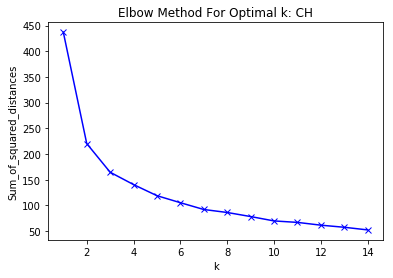

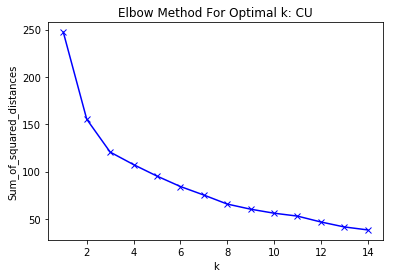

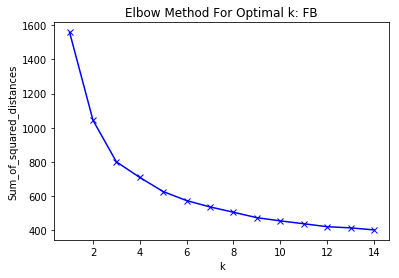

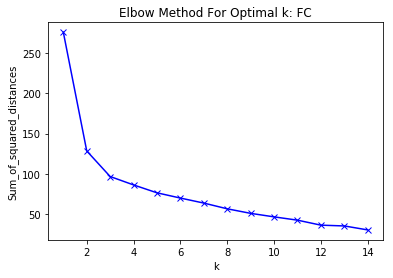

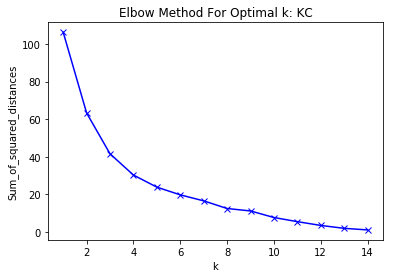

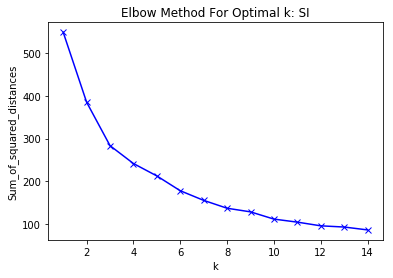

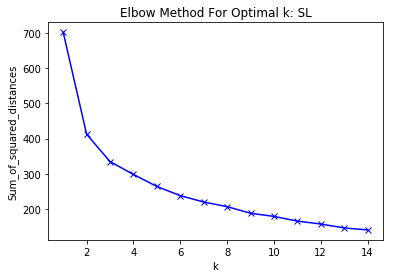

In [21]:
K = range(1, cluster_limit)
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        sum_of_squared_distances = []
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(group)
            models[pitch_type][k] = km
            sum_of_squared_distances.append(km.inertia_)
        plt.plot(K, sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k: ' + pitch_type)
        plt.show()

#### The clustering models by pitch type are stored in the means dict below (kmeans[pitch_type] returns a model to fit on new data)

In [22]:
kmeans = {}
kmeans['CH'] = models['CH'][8]
kmeans['CU'] = models['CU'][8]
kmeans['FC'] = models['FC'][7]
kmeans['FB'] = models['FB'][8]
kmeans['KC'] = models['KC'][8]
kmeans['SI'] = models['SI'][8]
kmeans['SL'] = models['SL'][8]
kmeans

{'CH': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'CU': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'FB': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'FC': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'KC': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'SI': KMeans(a

In [39]:
pickle.dump(kmeans, open("pitcher_clusters_kmeans.p", "wb"))

### GridSearch clustering pipeline

In [23]:
pipelines = {}
cluster_limit = 10

In [25]:
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        parameters = {'n_clusters': [i for i in range(1, cluster_limit)]}
        km = KMeans()
        grid = GridSearchCV(km, parameters)
        pipeline = Pipeline([('clusterer', grid)])
        pipeline.fit(group)
        pipelines[pitch_type] = pipeline
pipelines

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Ve

{'CH': Pipeline(memory=None,
      steps=[('clusterer', GridSearchCV(cv='warn', error_score='raise-deprecating',
        estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
        fit_params=None, iid='warn', n_jobs=None,
        param_grid={'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0))]), 'CU': Pipeline(memory=None,
      steps=[('clusterer', GridSearchCV(cv='warn', error_score='raise-deprecating',
        estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
        fit_params=None, iid='warn', n_jobs=None,
        param_grid={'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
        pre_dispatch='

### Evidence Accumulation Clustering (EAC)
#### Cluster data many times, record labels on each, see # times pair appears. First cluster data many times with KMeans, then apply hierarchical clustering on coassociation matrix. The hierarchical clustering in this case is same as finding minimum spanning tree.

In [26]:
def create_coassociation_matrix(labels):
    rows, cols = [], []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0] # where instead of which in R
        for index1 in indices: # for each pair of samples with same label, record both positions
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),)) # data has value 1 for every time two samples were listed together
    return csr_matrix((data, (rows, cols)), dtype='float')

# Create EAC clustering algorithm fitting scikit interface
class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=25, cut_threshold=0.5, n_clusters_range=(3,cluster_limit)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X)) 
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)

In [27]:
eac = {}

In [28]:
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        pipeline = Pipeline([('clusterer', EAC())])
        pipeline.fit(group)
        nEAC = pipeline.named_steps['clusterer'].n_clusterings
        print('{} clusters were found'.format(nEAC))
        eac[pitch_type] = pipeline
eac

25 clusters were found
25 clusters were found
25 clusters were found
25 clusters were found
25 clusters were found
25 clusters were found
25 clusters were found


{'CH': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'CU': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'FB': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'FC': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'KC': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'SI': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))]),
 'SL': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=25, n_clusters_range=(3, 10)))])}

## Generating Predictive Cluster Assignments

#### KMeans prediction example

In [31]:
pitchers

array([425844, 430935, 433587, 448306, 453281, 453286, 456034, 461829,
       462136, 471911, 501985, 502190, 502327, 502624, 518452, 518633,
       519242, 542881, 542882, 543294, 544931, 570632, 571666, 571760,
       572971, 592717, 592789, 592866, 593958, 594798, 594835, 596133,
       605182, 605400, 605483, 607231, 607536, 608337, 621389, 622072,
       622491, 625643, 640455, 642232, 656794, 670950, 434378, 446372,
       448179, 450203, 452657, 467100, 500779, 518516, 519144, 543243,
       543475, 543699, 571945, 572140, 592351, 592662, 592791, 593334,
       598264, 598271, 598287, 607625, 608566, 608717, 621244, 664192,
       112526, 407822, 407845, 425492, 429719, 433589, 434538, 434628,
       434671, 444468, 445926, 446099, 448281, 448802, 448855, 450306,
       451584, 451596, 451661, 453178, 453284, 453329, 453385, 456696,
       456701, 457918, 458677, 458681, 459429, 460283, 461325, 462382,
       465657, 468504, 473879, 475054, 475115, 476451, 476454, 477132,
      

In [29]:
pitch_type = 'FB'
group = X[X['pitch_type'] == pitch_type]
pitch = group.pitcher
group = group.drop(['pitch_type','pitcher'], 1)
labels = kmeans[pitch_type].predict(group)
labels

array([0, 5, 3, 3, 7, 3, 2, 1, 7, 6, 1, 3, 3, 4, 1, 6, 2, 1, 6, 3, 3, 6,
       3, 7, 4, 2, 4, 6, 1, 4, 3, 5, 6, 3, 3, 6, 6, 3, 6, 2, 3, 6, 7, 7,
       4, 7, 0, 4, 0, 3, 7, 0, 1, 2, 3, 2, 7, 3, 0, 0, 1, 2, 2, 6, 3, 3,
       3, 1, 1, 0, 3, 0, 3, 1, 0, 4, 0, 4, 3, 3, 0, 2, 2, 5, 7, 3, 4, 6,
       5, 3, 3, 3, 6, 3, 3, 3, 1, 0, 6, 4, 0, 6, 0, 0, 4, 4, 1, 3, 2, 4,
       5, 2, 7, 6, 1, 1, 3, 6, 7, 0, 3, 1, 4, 7, 0, 2, 2, 7, 6, 1, 3, 3,
       4, 6, 2, 3, 3, 0, 4, 0, 3, 3, 3, 6, 0, 2, 4, 6, 3, 7, 7, 7, 6, 6,
       3, 0, 1, 3, 0, 3, 2, 7, 3, 3, 3, 4, 7, 0, 7, 2, 1, 1, 6, 5, 7, 3,
       3, 4, 4, 1, 4, 1, 3, 1, 4, 0, 0, 6, 5, 1, 3, 1, 4, 0, 3, 5, 4, 2,
       1, 2, 0, 5, 1, 3, 3, 1, 7, 1, 4, 4, 1, 3, 0, 1, 7, 4, 4, 3, 2, 5,
       3, 3, 0, 3, 5, 6, 4, 1, 5, 7, 1, 2, 7, 0, 3, 2, 7, 7, 3, 2, 4, 4,
       3, 3, 1, 0, 3, 3, 2, 6, 1, 3, 0, 4, 4, 1, 0, 1, 6, 6, 6, 1, 0, 4,
       1, 3, 4, 0, 4, 3, 2, 6, 0, 3, 3, 2, 1, 3, 3, 1, 3, 6, 3, 1, 3, 7,
       1, 3, 2, 3, 0, 1, 3, 5, 6, 6, 1, 1, 6, 1, 3,

In [34]:
result = pd.DataFrame()
result['pitcher'], result['cluster'] = pitch, labels
result = pd.merge(result, pitchers)
result.head()

,pitcher,cluster,pitcher_name
0,112526,0,Bartolo Colon
1,407822,5,Jorge De La Rosa
2,407845,3,Fernando Rodney
3,425492,3,Ryan Madson
4,425844,7,Zack Greinke


In [35]:
clusters = pd.DataFrame()
for pitch_type in kmeans:
    group = X[X['pitch_type'] == pitch_type]
    pitch = group.pitcher
    group = group.drop(['pitch_type','pitcher'], 1)
    labels = kmeans[pitch_type].predict(group)
    result = pd.DataFrame()
    result['pitcher'], result['cluster'] = pitch, labels
    result = pd.merge(result, pitchers)
    result['pitch_type'] = pitch_type
    clusters = clusters.append(result)
clusters.head()

,pitcher,cluster,pitcher_name,pitch_type
0,448306,1,James Shields,KC
1,453178,4,Ian Kennedy,KC
2,476454,5,Dellin Betances,KC
3,502026,5,Jeremy Jeffress,KC
4,502085,1,David Robertson,KC


In [36]:
clusters.to_csv('pitcher_clusters.csv', index=False)